### Import libraries

In [172]:
import os
import sys
import copy
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

import networkx as nx

import torch

import matplotlib.pyplot as plt

DIR_PATH = Path.cwd()
sys.path.append(str(DIR_PATH))


from Models import MLP, VanillaGNN, GCN, GCONV, GAT, GIN
from Models.evaluation import test_n_times

from Dataset.data_loader import get_data
from Dataset.preprocessing import scale_adj, pad_ohe_features, scale_feature, get_train_val_test_masks
from Dataset import DatasetTabular, DatasetGraph
from Dataset.graph import to_data_list

from Visualization.eda import histogram_classes, feature_bar_plots, violin_plots, corr_mtrx
from Visualization.graph import vis_graph, plot_graphs

from utils import set_seed, set_device

%matplotlib inline
# reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Fix Seeds

In [173]:
seed=42
set_seed(seed)
device = set_device()

data_type = 'unbalanced' # 'unbalanced' 
DATA_PATH = DIR_PATH / 'Data'
fig_path = DIR_PATH / f'Figures/{data_type}'
os.makedirs(fig_path, exist_ok=True)

# Reinitialize graph data
shutil.rmtree(DATA_PATH / 'processed', ignore_errors=True)


results = {} # store the results 

Device: cuda


### Read the data

In [174]:
# load the adjacency matrices and the data
A, data = get_data(DATA_PATH, data_type)  

# Print information about the dataset
S, N = A.shape[0], A.shape[1]

display(data.head(5))

# store features in x (S, N, M) and labels in y (S, 1) 
x, y = np.expand_dims(data.iloc[:, 3:].values, axis=-1), np.expand_dims(data.iloc[:,2].values, axis=-1)
M = x.shape[-1]

print(f'Number of graphs: {S}')
print(f'Number of nodes: {N}')
print(f'Number of features per node: {M}')

# Check if every graph is connected
print(f'All connected: {all(nx.is_connected(nx.from_numpy_array(G)) for G in A)}')
print('Labels:', dict(zip(*np.unique(y, return_counts=True))))

,pat_id,conf,class,Prot1,Prot2,Prot3,Prot4,Prot5,Prot6,Prot7,...,Prot11,Prot12,Prot13,Prot14,Prot15,Prot16,Prot17,Prot18,Prot19,Prot20
0,1,0.165192,0,-0.288741,1.320418,1.246890,-0.587912,0.425350,1.433823,1.573993,...,1.338356,0.151599,1.333244,-0.893175,-0.736581,2.830105,-0.793974,-1.773393,2.129005,-0.543475
1,2,-0.513246,0,-1.300974,-1.309550,0.173989,-0.042006,-0.282135,3.165004,0.228712,...,0.997965,-0.101997,-0.223099,0.569135,1.335152,2.404228,0.422917,-3.614869,2.241441,-0.444110
2,3,-0.374802,1,-1.825425,1.211511,2.546314,0.161956,0.211815,4.396854,3.311472,...,-0.204465,-0.150981,1.128062,-0.049212,0.592243,-0.475274,-0.234234,-3.083168,3.457820,-1.471739
3,4,0.367808,1,0.449866,-0.493820,0.975631,1.253092,-1.101147,0.124996,1.165723,...,1.835069,-0.124808,1.011982,-0.066768,0.606598,4.985515,-0.124784,-1.378635,-0.934949,-1.366920
4,5,0.364785,0,-0.906779,-0.535000,1.317661,0.502248,2.241087,1.893090,0.866129,...,2.193369,1.083511,-1.530435,0.771263,-0.562726,1.368810,1.060422,-1.168465,0.812168,-1.684827


Number of graphs: 500
Number of nodes: 20
Number of features per node: 1
All connected: True
Labels: {0: 375, 1: 125}


### EDA

#### Nodes statistics

In [175]:
def get_avg_degree_centrality(A: np.array) -> np.float64:
  """Calculate the average degree centrality of an adjacency matrix."""
  return np.mean(list(dict(nx.degree_centrality(nx.from_numpy_array(A))).values()))

def get_avg_closeness_centrality(A: np.array) -> np.float64:
  """Calculate the average closeness centrality of an adjacency matrix."""
  return np.mean(list(dict(nx.closeness_centrality(nx.from_numpy_array(A))).values()))

def get_avg_betweenness_centrality(A: np.array) -> np.float64:
  """Calculate the average betweenness centrality of an adjacency matrix."""
  return np.mean(list(dict(nx.betweenness_centrality(nx.from_numpy_array(A))).values()))

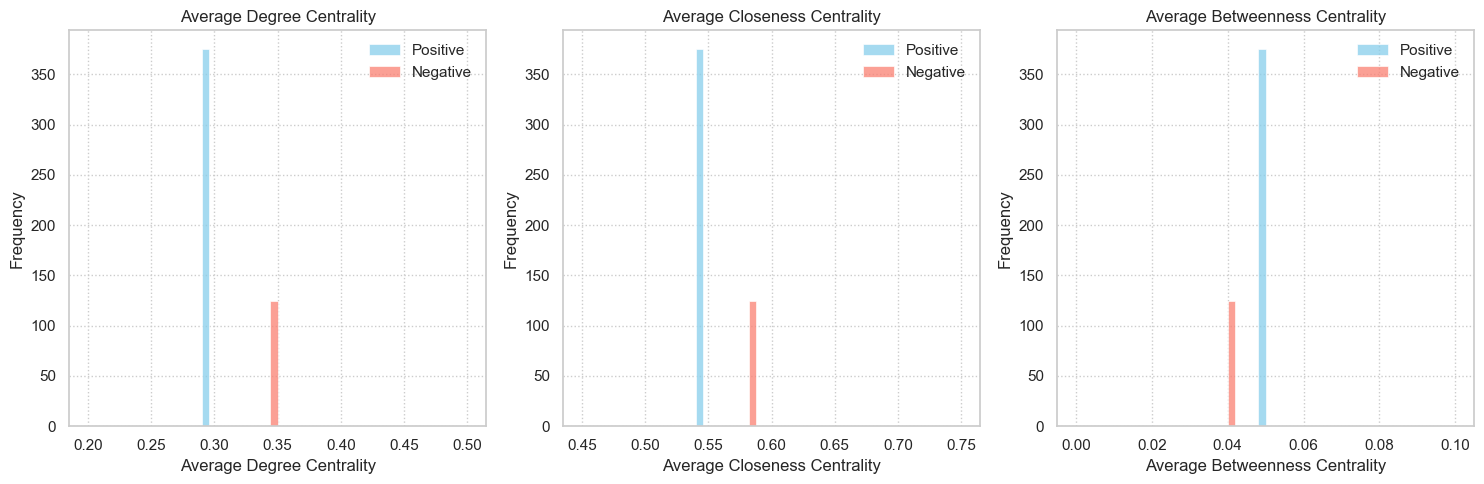

In [176]:
# Store the adjacency matrices for each of the classes
A_pos = A[np.where(y==0)[0]]
A_neg = A[np.where(y==1)[0]]

# Compute average degree centrality for each sample per class
deg_pos_mean = [get_avg_degree_centrality(a) for a in A_pos]
deg_neg_mean = [get_avg_degree_centrality(a) for a in A_neg]

# Compute average closeness centrality for each sample per class
cls_pos_mean = [get_avg_closeness_centrality(a) for a in A_pos]
cls_neg_mean = [get_avg_closeness_centrality(a) for a in A_neg]

# Compute average betweenness centrality for each sample per class
btw_pos_mean = [get_avg_betweenness_centrality(a) for a in A_pos]
btw_neg_mean = [get_avg_betweenness_centrality(a) for a in A_neg]


# Combine data and metrics into lists
pos_data = [deg_pos_mean, cls_pos_mean, btw_pos_mean]
neg_data = [deg_neg_mean, cls_neg_mean, btw_neg_mean]
metrics = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']
binranges = [(0.2, 0.5), (0.45, 0.75), (0, 0.1)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Iterate over the data and metrics to create each subplot
for i, (pos, neg, metric, binrange) in enumerate(zip(pos_data, neg_data, metrics, binranges)):
        _ = histogram_classes(pos, neg, metric, ax=axes[i], bins=50, binrange=binrange)  

fig.tight_layout()  # Adjust subplots to fit into figure area.
fig.savefig(fig_path / 'histogram.png')  # Save the figure before showing it.

Apparently, we can already differentiate between positive and negative based on just the graph structure. **A perfect classifier just using a threshold**, do we even need any GNNs after this? We will further analyze the node features to see if there is a similar way to distinguish between the classes and apply some SOTA GNN models.

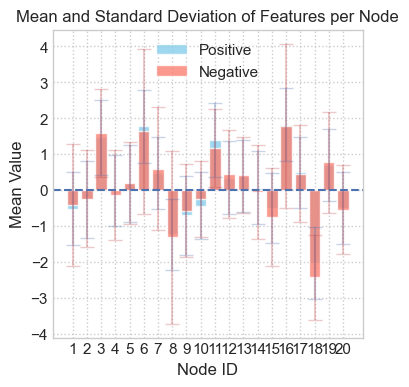

In [177]:
# plot the bars of mean and with std values
x_pos = x[np.where(y==0)[0]].squeeze()
x_neg = x[np.where(y==1)[0]].squeeze()

save_path = fig_path / 'bar_plot.png'
feature_bar_plots(x_pos, x_neg, save_path)

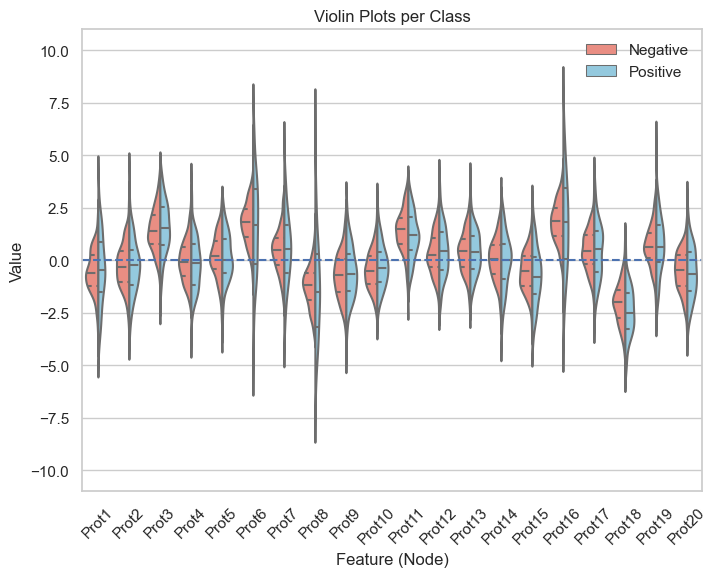

In [178]:
# Plot the violin plot of the features
df_melted = pd.melt(data, id_vars=['class'], 
                    value_vars=[f'Prot{i}' for i in range(1, N+1)], 
                    var_name='Protein', value_name='Expression')
                                                                                                                                                                                                                                                                                                                                                                                                   
save_path = fig_path / 'violins.png'
violin_plots(df_melted, save_path)

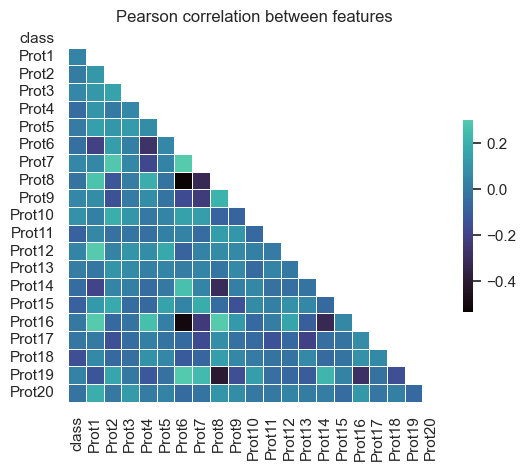

In [179]:
# Plot the correlation between the features
corr = data.iloc[:, 2:].corr()

save_path = fig_path / 'correlation.png'
corr_mtrx = corr_mtrx(corr, save_path)

#### Edges statistics

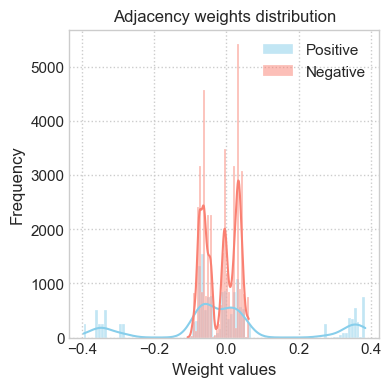

In [180]:
# Plot weights distribution of adjacency matrices
A_pos = A[np.where(y==1)[0]]
A_neg = A[np.where(y==0)[0]]

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(4, 4))
ax = histogram_classes(A_pos[A_pos!=0], A_neg[A_neg!=0], None, ax, kde=True)

ax.set_title('Adjacency weights distribution')
ax.set_xlabel('Weight values')

save_path = fig_path / 'Adj_weights_distr.png'
if save_path is not None:
    plt.savefig(save_path)
plt.show()

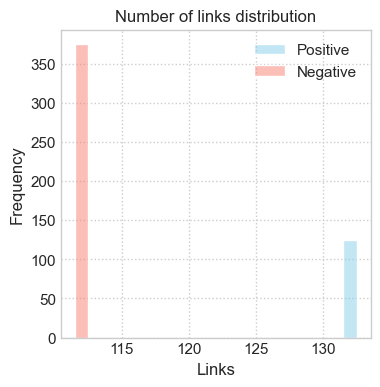

In [181]:
# Plot the distribution of the number of links per graph
num_links_pos = np.count_nonzero(A, axis=(1, 2))[np.where(y==1)[0]]
num_links_neg = np.count_nonzero(A, axis=(1, 2))[np.where(y==0)[0]]

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(4, 4))
ax = histogram_classes(num_links_pos, num_links_neg, None, ax, kde=True)

ax.set_title('Number of links distribution')
ax.set_xlabel('Links')

save_path = fig_path / 'Num_links_distr.png'
if save_path is not None:
    plt.savefig(save_path)
plt.show()

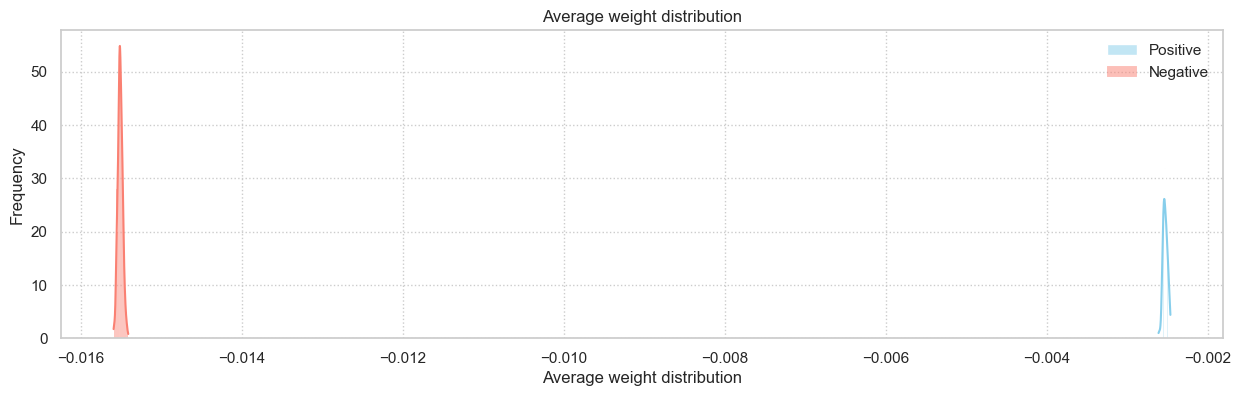

In [182]:
# Plot the distribution of an average weight per matrix
weights_pos = [a[a!=0].mean() for a in A_pos]
weights_neg = [a[a!=0].mean() for a in A_neg]

fig, ax = plt.subplots(figsize=(15, 4))
ax = histogram_classes(weights_pos, weights_neg, 'weight distribution', ax, kde=True)
save_path = fig_path / 'avg_weight_distr.png'
if save_path is not None:
    plt.savefig(save_path)
plt.show()

The features seem to have a Gaussian distribution. They do not provide a strong correlation with the **class** target, although some features, such as **Prot18**, **Prot11** seem to be more correlated, which is confirmed by the violin plats, which show a small difference in the mean values per class.

#### Graph visualization

Graph 1, Negative class


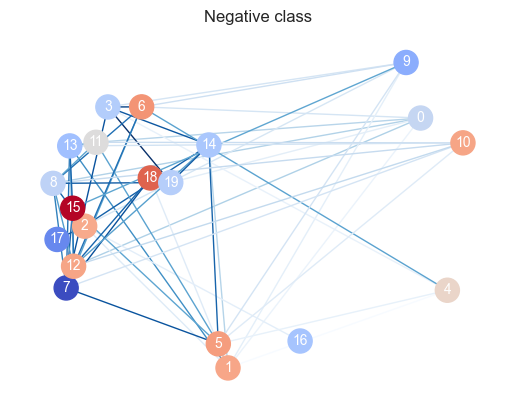

In [183]:
# Visualize one graph and color the nodes according to the feature values
idx = 0
label = 'Positive' if y[idx]==1 else 'Negative'

print(f'Graph {idx+1}, {label} class')

save_path = fig_path / f'graph_{label}.png'
vis_graph(A[idx], x[idx, :, 0], label, save_path)


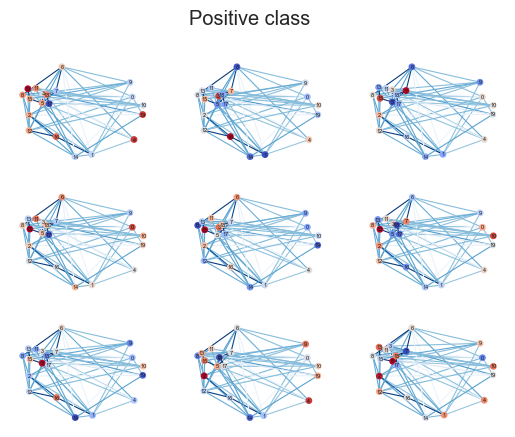

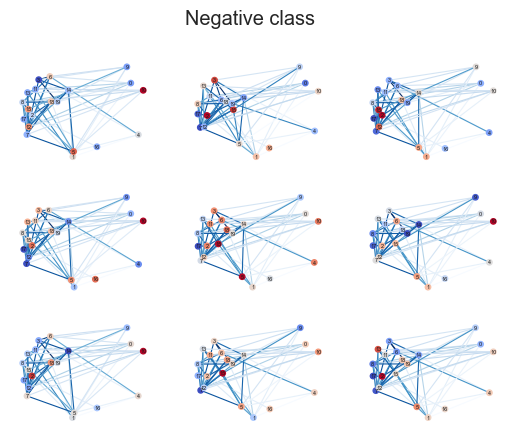

In [184]:
# Plot a few graphs of both classes together
save_path = fig_path / f'positive_graphs_{label}.png'
plot_graphs(A, x, y, 9, 'Positive', save_path)
save_path = fig_path / f'negative_graphs_{label}.png'
plot_graphs(A, x, y, 9, 'Negative', save_path)

## Data Preprocessing

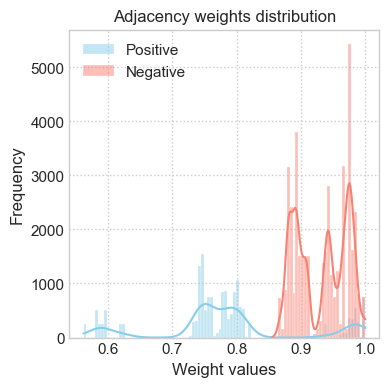

Number of samples: Training 350 | Validation 75 | Testing 75


In [185]:
SCALE_ADJ_WEIGHTS = True
ADD_OHE_FEATURES = True
NORMALIZE_FEATURES = False 
ADD_NODE2VEC = False


if SCALE_ADJ_WEIGHTS:
    # Scale the weights of the adjacency matrices
    A = scale_adj(A)    

     # Plot weights distribution of adjacency matrices
    A_pos = A[np.where(y==1)[0]]
    A_neg = A[np.where(y==0)[0]]

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = histogram_classes(A_pos[A_pos!=0], A_neg[A_neg!=0], None, ax, kde=True)

    ax.set_title('Adjacency weights distribution')
    ax.set_xlabel('Weight values')

    save_path = fig_path / 'Adj_weights_distr_norm.png'
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
if ADD_OHE_FEATURES:
    # Add the identifiers of each node as a OHE feature
    x = pad_ohe_features(x, N)
    # Number of features is increased by the number of nodes
    M += N
    
# Split the data into train, validation, and test sets
train_mask, val_mask, test_mask = get_train_val_test_masks(S, y)

if NORMALIZE_FEATURES: # TODO: Check this 
    # Standardize the features from a list features_id 
    features_id = [0] # list of features (columns) you want to scale
    for feature_id in features_id:
        x = scale_feature(x, feature_id, train_mask, val_mask, test_mask)
        
        # check the distribution
        data_scaled = np.hstack((x[:, :, feature_id], y))
        
        df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
        df_melted1 = pd.melt(df, id_vars=['class'], 
                            value_vars=[f'Prot{i}' for i in range(1, 21)], 
                            var_name='Protein', value_name='Expression')
        
        save_path = fig_path / f'violins_norm_{feature_id}.png'                                                                                                                                                                                                                                                                                                                                                              
        violin_plots(df_melted1, save_path)
        
if ADD_NODE2VEC:
    dim = 32

    from tqdm import tqdm
    from node2vec import Node2Vec

    x_ = torch.concat((torch.tensor(x, dtype=torch.float32), torch.zeros((x.shape[0], x.shape[1], dim), dtype=torch.float32)), dim=-1).to(device)

    for i in tqdm(range(A.shape[0])):
        # embedding for each graph
        G = nx.from_numpy_array(A[i])
        node2vec = Node2Vec(G, dimensions=dim, walk_length=20, num_walks=100, p=2, q=1, workers=20, quiet=True)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        x_[i, :, 1:] = torch.tensor(model.wv[np.arange(N)], dtype=torch.float32)
        
        #print(model.wv[np.arange(N)].shape)


In [186]:
from networkx.utils import graphs_equal

graphs_equal(nx.from_numpy_array(A[1]!=0), nx.from_numpy_array(A[2]!=0))

False

## Deep Learning Graph Classification

In [187]:
epochs = 300
num_sim = 5
num_layers = 2
dim_h = 16
dropout = True

### MLP
As a baseline model, we can firs us a classic MLP architecture, which completely ignores any topology of the dataset.

In [188]:
# Create datasets and convert to mini-batches
train_loader = DatasetTabular(x[train_mask], y[train_mask], device).to_loader(batch_size=64, shuffle=True)
val_loader = DatasetTabular(x[val_mask], y[val_mask], device).to_loader(batch_size=64, shuffle=True)
test_loader = DatasetTabular(x[test_mask], y[test_mask], device).to_loader(batch_size=64, shuffle=True)

Number of samples in the dataset: 350
Number of samples in the dataset: 75
Number of samples in the dataset: 75


In [189]:
mlp = MLP(dim_in=N*M, dim_h=dim_h, num_layers=num_layers).to(device)
print(mlp)
history_avg, history_test = test_n_times(mlp, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['MLP'] = (history_avg, history_test)

MLP(
  (linear): ModuleList(
    (0): Linear(in_features=420, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (classifier): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
Trial 1, test loss: 0.46 | test accuracy: 85.44%
Trial 2, test loss: 0.38 | test accuracy: 83.88%
Trial 3, test loss: 0.25 | test accuracy: 92.97%
Trial 4, test loss: 0.40 | test accuracy: 85.44%
Trial 5, test loss: 0.26 | test accuracy: 92.97%


### Prepare a graph dataset

In [190]:
data_list = to_data_list(A, x, y, device)
dataset = DatasetGraph(root='./Data', data_list=data_list) # delete the folder to reset

train_loader = dataset[train_mask].to_loader(batch_size=64, shuffle=True)
val_loader   = dataset[val_mask].to_loader(batch_size=64, shuffle=True)
test_loader  = dataset[test_mask].to_loader(batch_size=64, shuffle=True)

Number of samples in the dataset: 500


Processing...
Done!


### Vanilla GNN (manual)

In [191]:
gnn = VanillaGNN(dim_in=M, dim_h=dim_h, num_layers=num_layers).to(device)
print(gnn)
history_avg, history_test = test_n_times(gnn, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GNN (manual)'] = (history_avg, history_test)

VanillaGNNLayer(dim_in=21, dim_out=16)
VanillaGNNLayer(dim_in=16, dim_out=16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.01 | test accuracy: 100.00%
Trial 2, test loss: 0.01 | test accuracy: 100.00%
Trial 3, test loss: 0.01 | test accuracy: 100.00%
Trial 4, test loss: 0.01 | test accuracy: 100.00%
Trial 5, test loss: 0.00 | test accuracy: 100.00%


### GCN (manual)

In [192]:
gcn = GCN(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True, manual=True).to(device) # weights
print(gcn)
history_avg, history_test = test_n_times(gcn, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GCN (manual)'] = (history_avg, history_test)

VanillaGCNLayer(dim_in=21, dim_out=16)
VanillaGCNLayer(dim_in=16, dim_out=16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.08 | test accuracy: 100.00%
Trial 2, test loss: 0.10 | test accuracy: 99.22%
Trial 3, test loss: 0.11 | test accuracy: 100.00%
Trial 4, test loss: 0.10 | test accuracy: 99.22%
Trial 5, test loss: 0.08 | test accuracy: 99.22%


### GCN

In [193]:
gcn = GCN(dim_in=M, dim_h=dim_h, num_layers=num_layers, dropout=True, manual=False).to(device) 
print(gcn)
history_avg, history_test = test_n_times(gcn, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GCN'] = (history_avg, history_test)

GCNConv(21, 16)
GCNConv(16, 16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.18 | test accuracy: 98.44%
Trial 2, test loss: 0.18 | test accuracy: 94.67%
Trial 3, test loss: 0.17 | test accuracy: 98.44%
Trial 4, test loss: 0.15 | test accuracy: 98.44%
Trial 5, test loss: 0.16 | test accuracy: 98.44%


### GraphConv

In [194]:
gcn = GCONV(dim_in=M, dim_h=dim_h, num_layers=num_layers).to(device)
print(gcn)
history_avg, history_test = test_n_times(gcn, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GraphConv'] = (history_avg, history_test)

GraphConv(21, 16)
GraphConv(16, 16)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.01 | test accuracy: 100.00%
Trial 2, test loss: 0.01 | test accuracy: 100.00%
Trial 3, test loss: 0.01 | test accuracy: 100.00%
Trial 4, test loss: 0.01 | test accuracy: 100.00%
Trial 5, test loss: 0.01 | test accuracy: 100.00%


### GAT

In [195]:
gat = GAT(dim_in=M, dim_h=dim_h, num_layers=num_layers).to(device)
print(gat)
history_avg, history_test = test_n_times(gat, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GAT'] = (history_avg, history_test)

GATv2Conv(21, 16, heads=3)
GATv2Conv(48, 16, heads=1)
Pooling: add
Linear(in_features=16, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)

Trial 1, test loss: 0.03 | test accuracy: 100.00%
Trial 2, test loss: 0.03 | test accuracy: 100.00%
Trial 3, test loss: 0.04 | test accuracy: 100.00%
Trial 4, test loss: 0.04 | test accuracy: 100.00%
Trial 5, test loss: 0.03 | test accuracy: 100.00%


### GIN

In [196]:
gin = GIN(dim_in=M, dim_h=dim_h, num_layers=num_layers).to(device)
print(gin)
history_avg, history_test = test_n_times(gin, train_loader, val_loader, test_loader, epochs, num_sim, verbose=True)
results['GIN'] = (history_avg, history_test)

GINConv(nn=Sequential(
  (0): Linear(in_features=21, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): ReLU()
))
GINConv(nn=Sequential(
  (0): Linear(in_features=16, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): ReLU()
))
Pooling: add
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=1, bias=True)

Trial 1, test loss: 0.00 | test accuracy: 100.00%
Trial 2, test loss: 0.00 | test accuracy: 100.00%
Trial 3, test loss: 0.00 | test accuracy: 100.00%
Trial 4, test loss: 0.00 | test accuracy: 100.00%
Trial 5, test loss: 0.00 | test accuracy: 100.00%


Similar outpcomes are found in this **stack overflow** discussion [here](https://stackoverflow.com/questions/75752422/gnn-graph-classification-poor-performance)

### Performance comparison

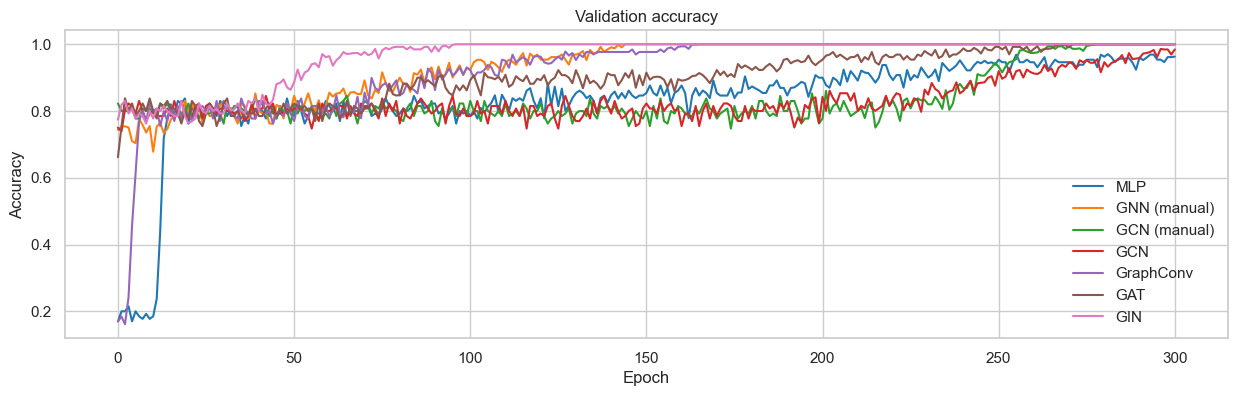

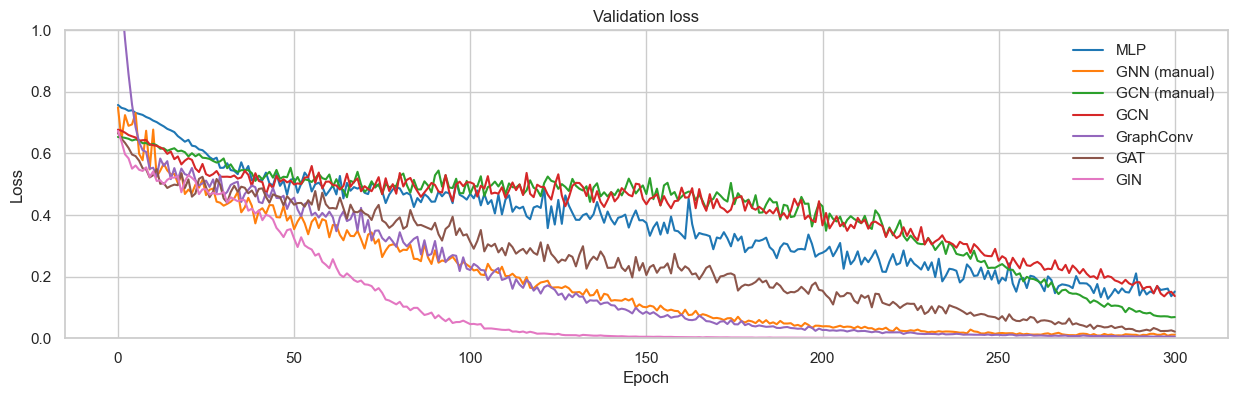

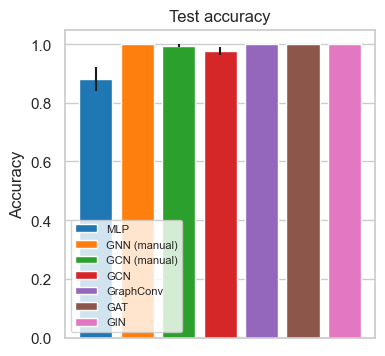

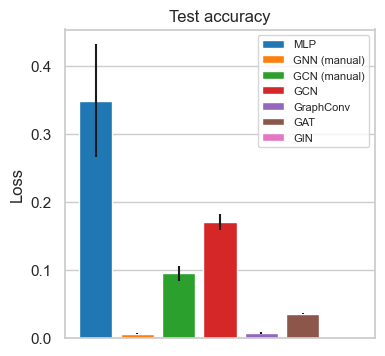

In [198]:
fig1, ax1 = plt.subplots(figsize=(15, 4)) # val performance (acc)
fig2, ax2 = plt.subplots(figsize=(15, 4)) # val performance (loss)
fig4, ax3 = plt.subplots(figsize=(4, 4)) # test performance (acc)
fig5, ax4 = plt.subplots(figsize=(4, 4)) # test_performance (loss)

colors = plt.get_cmap('tab10').colors

df_test = pd.DataFrame(columns=['Model', 'mean_loss', 'std_loss', 'mean_acc', 'std_acc'])
for i, (key, val) in enumerate(results.items()):
    history_val, test = val

    df_test.loc[len(df_test)] = [key, np.mean(test['test_loss']), np.std(test['test_loss']),
                    np.mean(test['test_acc']), np.std(test['test_acc'])]
    #ax1.plot(moving_average(history_val['val_acc'], 15), label=key)
    #ax2.plot(moving_average(history_val['val_loss'], 15), label=key)
    ax1.plot(history_val['val_acc'], label=key, color=colors[i])
    ax2.plot(history_val['val_loss'], label=key, color=colors[i])

ax1.legend()    
ax1.set_title('Validation accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.legend()    
ax2.set_title('Validation loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 1])

ax3.bar(df_test['Model'], df_test['mean_acc'], yerr=df_test['std_acc'], label=df_test['Model'], 
        color=[colors[c] for c in range(len(df_test))])
ax3.set_title('Test accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xticks([])
ax3.legend(frameon=True, loc='lower left', prop={'size': 8})  

ax4.bar(df_test['Model'], df_test['mean_loss'], yerr=df_test['std_loss'], label=df_test['Model'], 
        color=[colors[c] for c in range(len(df_test))])
ax4.set_title('Test accuracy')
ax4.set_ylabel('Loss')
ax4.set_xticks([])
ax4.legend(frameon=True, loc='upper right', prop={'size': 8})  

plt.show()    

## XAI: GNNExplainer and IntegratedGradients

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer, Explanation, CaptumExplainer


In [ ]:
# Different 
explainer = Explainer(
    model=model, 
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ))

data = dataset[-1]
#feature_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index)
explanation = explainer(x=data.x, edge_index=data.edge_index, batch=None)
print(explanation.node_mask)
#explanation.visualize_feature_importance(top_k=7)
explanation.visualize_graph(backend="networkx")

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',
    ),
    node_mask_type='attributes',
    edge_mask_type='object',
    threshold_config=dict(
        threshold_type='topk',
        value=1000,
    ),
)

node_index = 0
explanation = explainer(x=data.x, edge_index=data.edge_index, target=data.y, index=node_index)
explanation.visualize_graph()


In [199]:
#from torch_geometric.data import Data
#from torch_geometric.loader import DataLoader
#from scipy.sparse import coo_matrix

#def get_data(dataset, idx):
#    return list(map(dataset.__getitem__, idx))

#dataset = []
#for idx in range(len(A)):
#    edge_index = coo_matrix(A[idx])
#    sample = Data(x=x[idx], edge_index=np.vstack((edge_index.row, edge_index.col)), edge_weight=edge_index.data, y=y[idx])
#    dataset.append(sample)

#train_dataset = get_data(dataset, id_train) 
#val_dataset = get_data(dataset, id_val) 
#test_dataset = get_data(dataset, id_test) 

#print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")   

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [200]:

# Train standard scaler on training and validation data, then apply to test data
#SCALE_DATA = True # Scale or use raw features

#if SCALE_DATA:
#    scaler = StandardScaler()
#    # train the scaler on training and validation
#    scaler.fit(np.concatenate((x_train, x_val), axis=0).reshape(-1, M)) 
#    # apply the scaler to the data (prevent information leak to the test data)
#    print(x_train[0][0])
#    x_train = scaler.transform(x_train.reshape(-1, M)).reshape(x_train.shape)
#    print(x_train[0][0])
#    x_val = scaler.transform(x_val.reshape(-1, M)).reshape(x_val.shape)
#    X_test = scaler.transform(x_test.reshape(-1, M)).reshape(x_test.shape)

    # check the distribution
#    data_scaled = np.hstack((
#                            np.concatenate((x_train, x_val, x_test), axis=0).squeeze(), 
#                            np.concatenate((y_train, y_val, y_test))
#                            )
#                        )
#    df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
#    df_melted1 = pd.melt(df, id_vars=['class'], 
#                        value_vars=[f'Prot{i}' for i in range(1, 21)], 
#                        var_name='Protein', value_name='Expression')
#                                                                                                                                                                                                                                                                                                                                                                                                    
#    sns.set(style="whitegrid")
#    palette = {1: 'skyblue', 0: 'salmon'}
#    plt.figure(figsize=(10, 8))
#    ax = sns.violinplot(x='Protein', y='Expression', hue='class', data=df_melted1, split=True, inner="quart", palette=palette)
#    ax.legend(handles=ax.legend_.legendHandles, labels=['Negative', 'Positive'])
#    plt.axhline(y=0, color='b', linestyle='--')
#    plt.title('Violin Plots per Class (Scaled)')
#    plt.xlabel('Feature (Node)')
#    plt.ylabel('Value')
#    plt.xticks(rotation=45)
#    plt.ylim([-11, 11])
#    plt.show()

In [201]:
#N_sim = 20 # number of you simulate to get the average performance
#verbose = True
#res_mlp = []
#for i in range(N_sim):
#    # Create MLP model
#    mlp = MLP(dim_in=N*M, dim_h=16).to(device)
#    if i == 0:
#        print(mlp,'\n')
    
#    # Train
#    mlp.fit(data_mlp, epochs=150, verbose=verbose)
    
#    # Test
#    acc = mlp.test(data_mlp)
#    if verbose:
#        print(f'MLP test accuracy: {acc*100:.2f}%')
    
#    # Store the results
#    res_mlp.append(acc.detach().detach().cpu().numpy())

#res_mlp = np.array(res_mlp)
#print(f'\nMLP final accuracy: {np.mean(res_mlp)*100:.2f}%, std: {np.std(res_mlp)*100:.2f}%')